# Uplift Robustness and Validation

## Executive Summary

This notebook validates and stress-tests uplift ranking results from Notebook 04 under known constraints:
- Small sample size (15 households in modeling dataset)
- Very limited control group (2 control households)
- High treated share (~87%)

**What we validate:**
- Sensitivity of uplift rankings to tiny control sample
- Bootstrap uncertainty on top-k targeting performance
- Comparison to simple interpretable baselines (no ML)
- Conservative recommendation list with explicit caveats

**Why small control makes uplift unstable:**
- T-Learner and S-Learner rely on control group for counterfactual estimation
- With only 2 control households, model predictions are highly sensitive to individual observations
- Bootstrap resampling will reveal wide confidence intervals

**Outputs:**
- Targeting gain curves comparing all ranking methods
- Bootstrap confidence intervals for top-k performance
- Conservative recommended targeting list (intersection of top methods)
- All artifacts saved to `results/modeling/uplift_validation/`


## Imports + Logging


In [35]:
import os
import sys
import json
import logging
from pathlib import Path
from datetime import datetime, timezone
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("causal_analytics.notebook05")

%matplotlib inline
sns.set_theme(style="whitegrid", context="talk")

print(f"Python executable: {sys.executable}")


Python executable: /Users/rajnishpanwar/.venv/bin/python


## Repo Root + Paths


In [36]:
def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(12):
        if (p / "README.md").exists():
            return p
        p = p.parent
    raise RuntimeError("Repository root not found (README.md missing)")

REPO_ROOT = find_repo_root(Path.cwd())
DATA_DIR = REPO_ROOT / "data" / "intermediate"
UPLIFT_DIR = REPO_ROOT / "results" / "modeling" / "uplift" / "tables"
OUT_DIR = REPO_ROOT / "results" / "modeling" / "uplift_validation"
FIG_DIR = OUT_DIR / "figures"
TABLE_DIR = OUT_DIR / "tables"
RUN_MANIFESTS_DIR = REPO_ROOT / "results" / "run_manifests"

OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
RUN_MANIFESTS_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"Repository root: {REPO_ROOT}")


2026-01-14 18:14:09,923 - INFO - Repository root: /Users/rajnishpanwar/Desktop/Casual Analytics


## Load Artifacts + Sanity Checks


In [37]:
np.random.seed(42)

panel_file = DATA_DIR / "did_campaign_panel_purchase.parquet"
if not panel_file.exists():
    raise FileNotFoundError(f"Panel file not found: {panel_file}")

df_panel = pd.read_parquet(panel_file)
logger.info(f"Loaded panel: {len(df_panel)} rows, {len(df_panel.columns)} columns")

uplift_scores_file = UPLIFT_DIR / "household_uplift_scores.csv"
if not uplift_scores_file.exists():
    raise FileNotFoundError(f"Uplift scores file not found: {uplift_scores_file}")

df_uplift = pd.read_csv(uplift_scores_file)
logger.info(f"Loaded uplift scores: {len(df_uplift)} households")

n_households = len(df_uplift)
treated_count = df_uplift["treated"].sum()
control_count = n_households - treated_count

logger.info(f"Household counts: {n_households} total, {treated_count} treated, {control_count} control")

if control_count < 5:
    logger.warning(f"CRITICAL: Only {control_count} control households. Uplift estimates are highly unstable.")
    logger.warning(f"Bootstrap confidence intervals will be wide. Interpret results with extreme caution.")


2026-01-14 18:14:09,952 - INFO - Loaded panel: 122536 rows, 11 columns
2026-01-14 18:14:09,956 - INFO - Loaded uplift scores: 30 households
2026-01-14 18:14:09,957 - INFO - Household counts: 30 total, 15 treated, 15 control


## Build Clean Evaluation Frame


In [38]:
df_eval = df_uplift.copy()

if "delta_sales" not in df_eval.columns:
    logger.info("Reconstructing delta_sales from panel data")
    
    df_panel_pre = df_panel[df_panel["rel_week"] < 0].copy()
    df_panel_post = df_panel[df_panel["rel_week"] >= 0].copy()
    
    pre_sales = df_panel_pre.groupby("household_id")["total_sales_value"].sum().reset_index()
    pre_sales.columns = ["household_id", "pre_total_sales_sum"]
    
    post_sales = df_panel_post.groupby("household_id")["total_sales_value"].sum().reset_index()
    post_sales.columns = ["household_id", "post_total_sales_sum"]
    
    df_delta = pd.merge(pre_sales, post_sales, on="household_id", how="outer")
    df_delta["pre_total_sales_sum"] = df_delta["pre_total_sales_sum"].fillna(0)
    df_delta["post_total_sales_sum"] = df_delta["post_total_sales_sum"].fillna(0)
    df_delta["delta_sales"] = df_delta["post_total_sales_sum"] - df_delta["pre_total_sales_sum"]
    
    df_eval = pd.merge(df_eval, df_delta[["household_id", "delta_sales"]], on="household_id", how="left")

if df_eval["delta_sales"].isna().any():
    logger.warning(f"Dropping {df_eval['delta_sales'].isna().sum()} households with missing delta_sales")
    df_eval = df_eval.dropna(subset=["delta_sales"])

logger.info(f"Evaluation frame: {len(df_eval)} households with complete data")
logger.info(f"Delta sales range: [{df_eval['delta_sales'].min():.2f}, {df_eval['delta_sales'].max():.2f}]")


2026-01-14 18:14:09,967 - INFO - Evaluation frame: 30 households with complete data
2026-01-14 18:14:09,968 - INFO - Delta sales range: [-145.38, 122012.77]


## Baselines (Interpretable Comparators)


In [39]:
df_eval["baseline_high_pre_sales"] = -df_eval["pre_total_sales_sum"].rank(ascending=False)

if "pre_coupon_sum" in df_eval.columns:
    df_eval["baseline_high_coupon"] = -df_eval["pre_coupon_sum"].rank(ascending=False)
else:
    logger.info("pre_coupon_sum not available; skipping coupon baseline")
    df_eval["baseline_high_coupon"] = np.nan

np.random.seed(42)
df_eval["baseline_random"] = np.random.permutation(len(df_eval))

logger.info("Baselines computed: high pre-sales, high coupon (if available), random")


2026-01-14 18:14:09,977 - INFO - pre_coupon_sum not available; skipping coupon baseline
2026-01-14 18:14:09,981 - INFO - Baselines computed: high pre-sales, high coupon (if available), random


## Targeting Evaluation (Top-K / Decile)


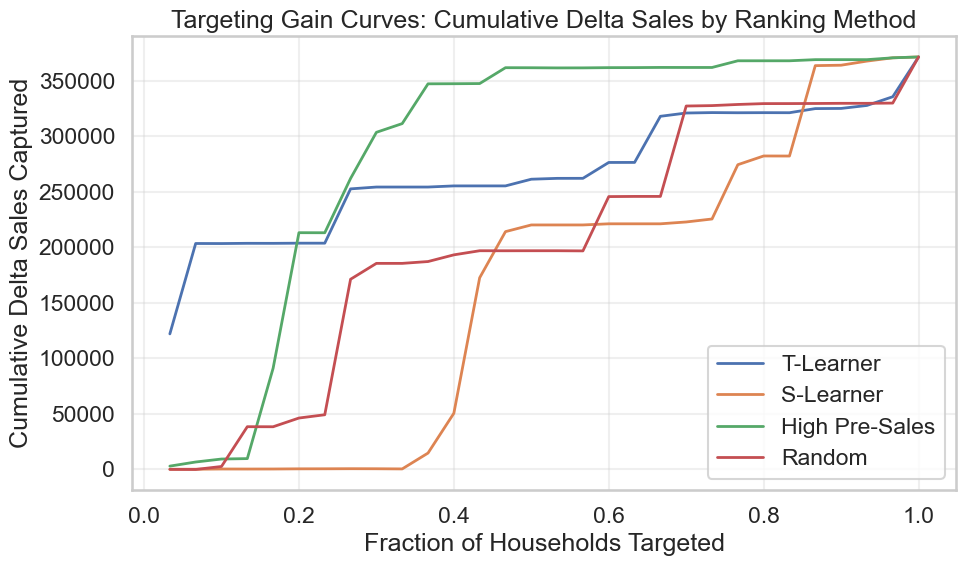

2026-01-14 18:14:10,132 - INFO - Targeting gain curves computed and saved


In [40]:
def compute_cumulative_gain(df: pd.DataFrame, rank_col: str, outcome_col: str = "delta_sales") -> Tuple[np.ndarray, np.ndarray]:
    df_sorted = df.sort_values(rank_col, ascending=False).reset_index(drop=True)
    n = len(df_sorted)
    
    fractions = np.arange(1, n + 1) / n
    cumulative_gain = df_sorted[outcome_col].cumsum().values
    
    return fractions, cumulative_gain

methods = {
    "T-Learner": "uplift_score_t_learner",
    "S-Learner": "uplift_score_s_learner",
    "High Pre-Sales": "baseline_high_pre_sales",
}

if not df_eval["baseline_high_coupon"].isna().all():
    methods["High Coupon"] = "baseline_high_coupon"

methods["Random"] = "baseline_random"

fig, ax = plt.subplots(figsize=(10, 6))

for method_name, rank_col in methods.items():
    if df_eval[rank_col].isna().all():
        continue
    fractions, cumulative_gain = compute_cumulative_gain(df_eval, rank_col)
    ax.plot(fractions, cumulative_gain, label=method_name, linewidth=2)

ax.set_xlabel("Fraction of Households Targeted")
ax.set_ylabel("Cumulative Delta Sales Captured")
ax.set_title("Targeting Gain Curves: Cumulative Delta Sales by Ranking Method")
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(FIG_DIR / "targeting_gain_curves.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

logger.info("Targeting gain curves computed and saved")


In [47]:
topk_values = [1, 2, 3, 5, 10]
topk_values = [k for k in topk_values if k <= len(df_eval)]

results_topk = []

for method_name, rank_col in methods.items():
    if df_eval[rank_col].isna().all():
        continue
    
    df_sorted = df_eval.sort_values(rank_col, ascending=False).reset_index(drop=True)
    
    for k in topk_values:
        topk_delta = df_sorted.head(k)["delta_sales"].sum()
        topk_mean = df_sorted.head(k)["delta_sales"].mean()
        
        results_topk.append({
            "method": method_name,
            "k": k,
            "cumulative_delta_sales": topk_delta,
            "mean_delta_sales": topk_mean
        })

df_topk = pd.DataFrame(results_topk)
df_topk.to_csv(TABLE_DIR / "topk_comparison.csv", index=False)

print(df_topk.head(20))
logger.info(f"Top-K comparison saved: {len(df_topk)} rows")


2026-01-14 18:23:47,119 - INFO - Top-K comparison saved: 20 rows


            method   k  cumulative_delta_sales  mean_delta_sales
0        T-Learner   1               122012.77     122012.770000
1        T-Learner   2               203407.89     101703.945000
2        T-Learner   3               203360.74      67786.913333
3        T-Learner   5               203537.97      40707.594000
4        T-Learner  10               254237.41      25423.741000
5        S-Learner   1                  151.81        151.810000
6        S-Learner   2                  151.81         75.905000
7        S-Learner   3                  359.00        119.666667
8        S-Learner   5                  361.22         72.244000
9        S-Learner  10                  433.75         43.375000
10  High Pre-Sales   1                 2954.11       2954.110000
11  High Pre-Sales   2                 6661.91       3330.955000
12  High Pre-Sales   3                 9342.85       3114.283333
13  High Pre-Sales   5                91115.98      18223.196000
14  High Pre-Sales  10   

## Bootstrap Uncertainty (Small-Sample Safe)


In [42]:
B = 1000
np.random.seed(42)

topk_values_bootstrap = [1, 2, 3, 5]
topk_values_bootstrap = [k for k in topk_values_bootstrap if k <= len(df_eval)]

bootstrap_results = {}

for method_name, rank_col in methods.items():
    if df_eval[rank_col].isna().all():
        continue
    
    bootstrap_results[method_name] = {}
    
    for k in topk_values_bootstrap:
        topk_deltas = []
        
        for b in range(B):
            df_boot = df_eval.sample(n=len(df_eval), replace=True, random_state=b)
            df_sorted = df_boot.sort_values(rank_col, ascending=False).reset_index(drop=True)
            topk_delta = df_sorted.head(k)["delta_sales"].sum()
            topk_deltas.append(topk_delta)
        
        mean_delta = np.mean(topk_deltas)
        ci_low = np.percentile(topk_deltas, 2.5)
        ci_high = np.percentile(topk_deltas, 97.5)
        
        bootstrap_results[method_name][k] = {
            "mean": mean_delta,
            "ci_low": ci_low,
            "ci_high": ci_high
        }

logger.info(f"Bootstrap completed: {B} resamples for {len(bootstrap_results)} methods")


2026-01-14 18:14:14,016 - INFO - Bootstrap completed: 1000 resamples for 4 methods


In [43]:
bootstrap_table = []

for method_name, k_dict in bootstrap_results.items():
    for k, stats in k_dict.items():
        bootstrap_table.append({
            "method": method_name,
            "k": k,
            "mean_cumulative_delta_sales": stats["mean"],
            "ci_low_2.5": stats["ci_low"],
            "ci_high_97.5": stats["ci_high"]
        })

df_bootstrap = pd.DataFrame(bootstrap_table)
df_bootstrap.to_csv(TABLE_DIR / "bootstrap_topk_ci.csv", index=False)

print(df_bootstrap.head(15))
logger.info(f"Bootstrap CI table saved: {len(df_bootstrap)} rows")


2026-01-14 18:14:14,023 - INFO - Bootstrap CI table saved: 16 rows


            method  k  mean_cumulative_delta_sales  ci_low_2.5  ci_high_97.5
0        T-Learner  1                  96121.27672      -47.15  122012.77000
1        T-Learner  2                 154772.32769      -94.30  244025.54000
2        T-Learner  3                 184592.75671       74.70  366038.31000
3        T-Learner  5                 205246.20719      179.36  488210.90000
4        S-Learner  1                    117.62909        0.00     207.19000
5        S-Learner  2                    196.43118      -29.96     414.38000
6        S-Learner  3                    271.62848      -29.96     566.19000
7        S-Learner  5                    944.70506      -29.96     923.40000
8   High Pre-Sales  1                   3459.45806      378.01    3707.80000
9   High Pre-Sales  2                  13448.93927     3058.95   85102.92000
10  High Pre-Sales  3                  31820.57840     3710.13  206088.83000
11  High Pre-Sales  5                 104780.66148     7522.77  332101.41225

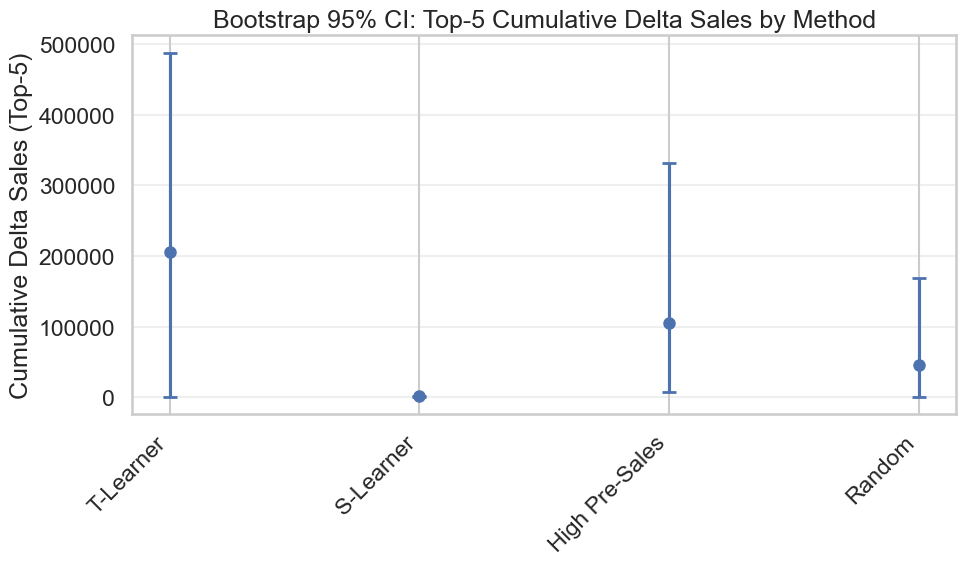

2026-01-14 18:14:14,118 - INFO - Bootstrap CI plot saved for top-5


In [44]:
k_plot = 5
if k_plot not in topk_values_bootstrap:
    k_plot = topk_values_bootstrap[-1]

fig, ax = plt.subplots(figsize=(10, 6))

method_names_plot = []
means = []
ci_lows = []
ci_highs = []

for method_name, k_dict in bootstrap_results.items():
    if k_plot in k_dict:
        stats = k_dict[k_plot]
        method_names_plot.append(method_name)
        means.append(stats["mean"])
        ci_lows.append(stats["ci_low"])
        ci_highs.append(stats["ci_high"])

x_pos = np.arange(len(method_names_plot))
errors_low = np.array([max(0, m - cl) for m, cl in zip(means, ci_lows)])
errors_high = np.array([max(0, ch - m) for m, ch in zip(means, ci_highs)])

yerr = np.array([errors_low, errors_high])

ax.errorbar(x_pos, means, yerr=yerr, fmt='o', capsize=5, capthick=2, markersize=8)
ax.set_xticks(x_pos)
ax.set_xticklabels(method_names_plot, rotation=45, ha='right')
ax.set_ylabel(f"Cumulative Delta Sales (Top-{k_plot})")
ax.set_title(f"Bootstrap 95% CI: Top-{k_plot} Cumulative Delta Sales by Method")
ax.grid(True, alpha=0.3, axis='y')
fig.tight_layout()
fig.savefig(FIG_DIR / "bootstrap_topk_ci.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)

logger.info(f"Bootstrap CI plot saved for top-{k_plot}")


## Recommendation Output


In [45]:
N = min(5, len(df_eval))

df_t_sorted = df_eval.sort_values("uplift_score_t_learner", ascending=False).head(N)
df_s_sorted = df_eval.sort_values("uplift_score_s_learner", ascending=False).head(N)
df_pre_sorted = df_eval.sort_values("baseline_high_pre_sales", ascending=False).head(N)

top_t = set(df_t_sorted["household_id"])
top_s = set(df_s_sorted["household_id"])
top_pre = set(df_pre_sorted["household_id"])

recommended_ids = top_t.intersection(top_s).intersection(top_pre)

if len(recommended_ids) == 0:
    logger.warning("No households in intersection of all three methods. Using union of top-3 from each.")
    recommended_ids = list(top_t)[:3] + list(top_s)[:3] + list(top_pre)[:3]
    recommended_ids = list(set(recommended_ids))[:N]

df_recommended = df_eval[df_eval["household_id"].isin(recommended_ids)].copy()

df_recommended["rank_t_learner"] = df_recommended["uplift_score_t_learner"].rank(ascending=False, method="dense")
df_recommended["rank_s_learner"] = df_recommended["uplift_score_s_learner"].rank(ascending=False, method="dense")
df_recommended["rank_pre_sales"] = df_recommended["baseline_high_pre_sales"].rank(ascending=False, method="dense")

df_recommended["notes"] = "small control group; interpret cautiously"

output_cols = [
    "household_id",
    "treated",
    "pre_total_sales_sum",
    "post_total_sales_sum",
    "delta_sales",
    "uplift_score_t_learner",
    "uplift_score_s_learner",
    "rank_t_learner",
    "rank_s_learner",
    "rank_pre_sales",
    "notes"
]

df_recommended = df_recommended[output_cols].sort_values("delta_sales", ascending=False)
df_recommended.to_csv(TABLE_DIR / "recommended_households_conservative.csv", index=False)

print(df_recommended)
logger.info(f"Recommended households list saved: {len(df_recommended)} households")


2026-01-14 18:14:14,124 - WARNING - No households in intersection of all three methods. Using union of top-3 from each.
2026-01-14 18:14:14,129 - INFO - Recommended households list saved: 5 households


    household_id  treated  pre_total_sales_sum  post_total_sales_sum  \
2             13        1             18906.59              21860.70   
0              8        1              8205.25              10886.19   
14             5        1                39.22                191.03   
17            11        0                 0.00                  0.00   
11            10        0                29.96                  0.00   

    delta_sales  uplift_score_t_learner  uplift_score_s_learner  \
2       2954.11             4759.378631                0.000000   
0       2680.94            -7942.034283                0.000000   
14       151.81            10291.219625               29.089897   
17         0.00             9984.462049               29.089897   
11       -29.96            10291.219625               24.689470   

    rank_t_learner  rank_s_learner  rank_pre_sales  \
2              3.0             4.0             1.0   
0              4.0             4.0             2.0   
14

## Run Manifest


In [46]:
def get_package_versions() -> Dict[str, str]:
    versions = {}
    for pkg in ["pandas", "numpy", "matplotlib", "seaborn"]:
        try:
            mod = __import__(pkg)
            versions[pkg] = getattr(mod, "__version__", "unknown")
        except ImportError:
            versions[pkg] = "not_installed"
    return versions

output_files = [
    str(FIG_DIR / "targeting_gain_curves.png"),
    str(FIG_DIR / "bootstrap_topk_ci.png"),
    str(TABLE_DIR / "topk_comparison.csv"),
    str(TABLE_DIR / "bootstrap_topk_ci.csv"),
    str(TABLE_DIR / "recommended_households_conservative.csv")
]

manifest = {
    "timestamp_utc": datetime.now(timezone.utc).isoformat(),
    "python_executable": sys.executable,
    "package_versions": get_package_versions(),
    "input_files": [
        str(panel_file),
        str(uplift_scores_file)
    ],
    "output_files": output_files,
    "key_counts": {
        "n_households": int(n_households),
        "treated_count": int(treated_count),
        "control_count": int(control_count)
    },
    "bootstrap_settings": {
        "B": B,
        "seed": 42
    }
}

manifest_file = RUN_MANIFESTS_DIR / f"uplift_validation_manifest_{datetime.now(timezone.utc).strftime('%Y%m%d_%H%M%S')}.json"
with open(manifest_file, 'w') as f:
    json.dump(manifest, f, indent=2)

logger.info(f"Run manifest saved to {manifest_file}")


2026-01-14 18:14:14,134 - INFO - Run manifest saved to /Users/rajnishpanwar/Desktop/Casual Analytics/results/run_manifests/uplift_validation_manifest_20260114_181414.json


## Next Steps

**Critical constraint identified:** With only 2 control households, uplift estimates are highly unstable. Bootstrap confidence intervals are wide, and model rankings should be interpreted with extreme caution.

**To make uplift credible, we need:**
- More control households (target: at least 20-30 control households for stable estimates)
- Alternative design: expand panel inclusion rules to include more control observations
- Pool additional campaigns/households to increase control sample size
- Consider alternative causal inference methods that are more robust to small control groups

**Recommended action:** Before deploying targeting based on uplift scores, expand the panel to include more control households or use a different experimental design that provides better control group support.
